In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from collections import defaultdict
import os, re
import random

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
INFO:tensorflow:Disabling eager execution


## 1. Data Processing

In [2]:
# Collect data and build vocabulary
def gen_data_and_vocab():
    def collect_data_from(parent_path, newsgroup_list, word_count=None):
        data = []
        for group_id, newsgroup in enumerate(newsgroup_list):
            dir_path = parent_path + '/' + newsgroup + '/'

            files = [(filename, dir_path + filename)
                        for filename in os.listdir(dir_path) if os.path.isfile(dir_path + filename)]
            files.sort()
            label = group_id
            print('Processing: {}-{}'.format(group_id, newsgroup))

            for filename, filepath in files:
                with open(filepath) as f:
                    text = f.read().lower()
                    words = re.split('\W+', text)
                    if word_count is not None:
                        for word in words:
                            word_count[word] += 1
                    content = ' '.join(words)
                    assert len(content.splitlines()) == 1
                    data.append(str(label) + '<fff>' + filename + '<fff>' + content)
        return data

    word_count = defaultdict(int)
    path = '../datasets/20news-bydate/'
    parts = [path + dir_name + '/' for dir_name in os.listdir(path)
                if not os.path.isfile(path + dir_name)]
    train_path, test_path = (parts[0], parts[1]) if 'train' in parts[0] else (parts[1], parts[0])

    newsgroup_list = [newsgroup for newsgroup in os.listdir(train_path)]
    newsgroup_list.sort()

    train_data = collect_data_from(
        parent_path=train_path,
        newsgroup_list=newsgroup_list,
        word_count=word_count
    )

    vocab = [word for word, freq in zip(word_count.keys(), word_count.values()) if freq > 10]
    vocab.sort()
    with open('../datasets/w2v/vocab-raw.txt', 'w') as f:
        f.write('\n'.join(vocab))
    test_data = collect_data_from(
        parent_path=test_path,
        newsgroup_list=newsgroup_list
    )

    with open('../datasets/w2v/20news-train-raw.txt', 'w') as f:
        f.write('\n'.join(train_data))

    with open('../datasets/w2v/20news-test-raw.txt', 'w') as f:
        f.write('\n'.join(test_data))

In [4]:
# Encode data
def encode_data(data_path, vocab_path):
    unknown_ID = 1
    padding_ID = 2
    with open(vocab_path) as f:
        vocab = dict([(word, word_ID + 2)
                    for word_ID, word in enumerate(f.read().splitlines())])
    with open(data_path) as f:
        documents = [(line.split('<fff>')[0], line.split('<fff>')[1], line.split('<fff>')[2]) for line in f.read().splitlines()]
    encoded_data = []
    for document in documents:
        label, doc_id, text = document
        words = text.split()[:MAX_SENTENCE_LENGTH]
        sentence_length = len(words)
        encoded_text = []
        for word in words:
            if word in vocab:
                encoded_text.append(str(vocab[word]))
            else:
                encoded_text.append(str(unknown_ID))
        
        if len(words) < MAX_SENTENCE_LENGTH:
            num_padding = MAX_SENTENCE_LENGTH - len(words)
            for _ in range(num_padding):
                encoded_text.append(str(padding_ID))

        encoded_data.append(str(label) + '<fff>' + str(doc_id) + '<fff>'
                            + str(sentence_length) + '<fff>' + ' '.join(encoded_text))
        
    dir_name = '/'.join(data_path.split('/')[:-1])
    file_name = '-'.join(data_path.split('/')[-1].split('-')[:-1]) + '-encoded.txt'
    with open(dir_name + '/' + file_name, 'w') as f:
        f.write('\n'.join(encoded_data))

In [3]:
MAX_SENTENCE_LENGTH = 500
NUM_CLASSES = 20

In [5]:
gen_data_and_vocab()
train_data_path = '../datasets/w2v/20news-train-raw.txt'
test_data_path = '../datasets/w2v/20news-test-raw.txt'
vocab_path = '../datasets/w2v/vocab-raw.txt'
encode_data(train_data_path, vocab_path)
encode_data(test_data_path, vocab_path)

Processing: 0-alt.atheism
Processing: 1-comp.graphics
Processing: 2-comp.os.ms-windows.misc
Processing: 3-comp.sys.ibm.pc.hardware
Processing: 4-comp.sys.mac.hardware
Processing: 5-comp.windows.x
Processing: 6-misc.forsale
Processing: 7-rec.autos
Processing: 8-rec.motorcycles
Processing: 9-rec.sport.baseball
Processing: 10-rec.sport.hockey
Processing: 11-sci.crypt
Processing: 12-sci.electronics
Processing: 13-sci.med
Processing: 14-sci.space
Processing: 15-soc.religion.christian
Processing: 16-talk.politics.guns
Processing: 17-talk.politics.mideast
Processing: 18-talk.politics.misc
Processing: 19-talk.religion.misc
Processing: 0-alt.atheism
Processing: 1-comp.graphics
Processing: 2-comp.os.ms-windows.misc
Processing: 3-comp.sys.ibm.pc.hardware
Processing: 4-comp.sys.mac.hardware
Processing: 5-comp.windows.x
Processing: 6-misc.forsale
Processing: 7-rec.autos
Processing: 8-rec.motorcycles
Processing: 9-rec.sport.baseball
Processing: 10-rec.sport.hockey
Processing: 11-sci.crypt
Processing

## 2. Build Model

In [17]:
# Build computation class
class RNN:
    def __init__(self,
                vocab_size,
                embedding_size,
                lstm_size,
                batch_size):
        self._vocab_size = vocab_size
        self._embedding_size = embedding_size
        self._lstm_size = lstm_size
        self._batch_size = batch_size

        self._data = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, MAX_SENTENCE_LENGTH])
        self._labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, ])
        self._sentence_lengths = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, ])
        self._final_tokens = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, ])

    def embedding_layer(self, indices):
        pretrained_vectors = []
        pretrained_vectors.append(np.zeros(self._embedding_size))
        np.random.seed(2018)
        for _ in range(self._vocab_size + 1):
                pretrained_vectors.append(np.random.normal(loc=0., scale=1., size=self._embedding_size))

        pretrained_vectors = np.array(pretrained_vectors)

        self._embedding_matrix = tf.compat.v1.get_variable(
                name='embedding',
                shape=(self._vocab_size + 2, self._embedding_size)
        )

        return tf.nn.embedding_lookup(self._embedding_matrix, indices)

    def LSTM_layer(self, embeddings):
            lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(self._lstm_size)
            zero_state = tf.zeros(shape=(self._batch_size, self._lstm_size))
            initial_state = tf.compat.v1.nn.rnn_cell.LSTMStateTuple(zero_state, zero_state)

            lstm_inputs = tf.unstack(
                    tf.transpose(embeddings, perm=[1, 0, 2])
            )
            lstm_outputs, last_state = tf.compat.v1.nn.static_rnn(
                    cell=lstm_cell,
                    inputs=lstm_inputs,
                    initial_state=initial_state,
                    sequence_length=self._sentence_lengths
            )
            lstm_outputs = tf.unstack(
                    tf.transpose(lstm_outputs, perm=[1, 0, 2])
            )
            lstm_outputs = tf.concat(
                    lstm_outputs,
                    axis=0
            ) # [num_docs * MAX_SENTENCE_LENGTH, lstm_size]

            # self._mask : [num_docs * MAX_SENTENCE_LENGTH, ]
            mask = tf.sequence_mask(
                    lengths=self._sentence_lengths,
                    maxlen=MAX_SENTENCE_LENGTH,
                    dtype=tf.float32
            ) # [num_docs, MAX_SENTENCE_LENGTH]
            mask = tf.concat(tf.unstack(mask, axis=0), axis=0)
            mask = tf.expand_dims(mask, -1)

            lstm_outputs = mask * lstm_outputs
            lstm_outputs_split = tf.split(lstm_outputs, num_or_size_splits=self._batch_size)
            lstm_outputs_sum = tf.reduce_sum(lstm_outputs_split, axis=1)
            lstm_outputs_average = lstm_outputs_sum  / tf.expand_dims(
                    tf.cast(self._sentence_lengths, tf.float32),
                    -1
            )
            return lstm_outputs_average

    def build_graph(self):
        embeddings = self.embedding_layer(self._data)
        lstm_ouputs = self.LSTM_layer(embeddings)

        weights = tf.compat.v1.get_variable(
                name='final_layer_weights',
                shape=(self._lstm_size, NUM_CLASSES),
                initializer=tf.random_normal_initializer(seed=2018)
        )

        biases = tf.compat.v1.get_variable(
                name='final_layer_biases',
                shape=(NUM_CLASSES),
                initializer=tf.random_normal_initializer(seed=2018)
        )

        logits = tf.matmul(lstm_ouputs, weights) + biases

        labels_one_hot = tf.one_hot(
                indices=self._labels,
                depth=NUM_CLASSES,
                dtype=tf.float32
        )

        loss = tf.nn.softmax_cross_entropy_with_logits(
                labels=labels_one_hot,
                logits=logits
        )

        loss = tf.reduce_mean(loss)

        probs = tf.nn.softmax(logits)
        predicted_labels = tf.argmax(probs, axis=1)
        predicted_labels = tf.squeeze(predicted_labels)
        return predicted_labels, loss
    def trainer(self, loss, learning_rate):
        with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(),reuse=tf.compat.v1.AUTO_REUSE): 
                train_op = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
        return train_op

    

In [18]:
class DataReader:
    def __init__(self, data_path, batch_size, vocab_size):
        self._batch_size = batch_size
        with open(data_path) as f:
            d_lines = f.read().splitlines()
        
        self._data = []
        self._sentence_lengths = []
        self._labels = []
        self._final_tokens = [] 
        for data_id, line in enumerate(d_lines):
            features = line.split('<fff>')
            label, doc_id, sentence_length = int(features[0]), int(features[1]), int(features[2])
            tokens = features[3].split()

            self._data.append(tokens)
            
            self._sentence_lengths.append(sentence_length)
            self._labels.append(label)
            self._final_tokens.append(tokens[-1])

        self._data = np.array(self._data)
        self._labels = np.array(self._labels)
        self._sentence_lengths = np.array(self._sentence_lengths)
        self._final_tokens = np.array(self._final_tokens)
        self._size = int(len(self._data) / self._batch_size) * self._batch_size

        self._num_epoch = 0
        self._batch_id = 0   

    def next_batch(self):
        start = self._batch_id * self._batch_size
        end = start + self._batch_size
        self._batch_id += 1

        if end + self._batch_size > len(self._data):
            self._num_epoch += 1
            self._batch_id = 0
            indices = list(range(len(self._data)))
            random.seed(2021)
            random.shuffle(indices)
            self._data, self._labels, self._sentence_lengths, self._final_tokens = self._data[indices], self._labels[indices], self._sentence_lengths[indices], self._final_tokens[indices]
        return self._data[start:end], self._labels[start:end], self._sentence_lengths[start:end], self._final_tokens[start:end]


In [19]:
losses = []
accuracy = []
MAX_STEP = 3300

In [20]:
def train_and_evaluate_RNN():
    with open('../datasets/w2v/vocab-raw.txt') as f:
        vocab_size = len(f.read().splitlines())
    tf.compat.v1.set_random_seed(2018)
    rnn = RNN(
        vocab_size=vocab_size,
        embedding_size=300,
        lstm_size=50,
        batch_size=50
    )
    predicted_labels, loss = rnn.build_graph()
    train_op = rnn.trainer(loss=loss, learning_rate=0.01)

    with tf.compat.v1.Session() as sess:
        train_data_reader = DataReader(
            data_path='../datasets/w2v/20news-train-encoded.txt',
            batch_size=50,
            vocab_size=vocab_size
        )
        test_data_reader = DataReader(
            data_path='../datasets/w2v/20news-test-encoded.txt',
            batch_size=50,
            vocab_size=vocab_size
        )
        step = 0
        
        sess.run(tf.compat.v1.global_variables_initializer())
        while step < MAX_STEP:
            next_train_batch = train_data_reader.next_batch()
            train_data, train_labels, train_sentence_lengths, train_final_tokens = next_train_batch
            plabels_eval, loss_eval, _ = sess.run(
                [predicted_labels, loss, train_op],
                feed_dict={
                    rnn._data: train_data,
                    rnn._labels: train_labels,
                    rnn._sentence_lengths: train_sentence_lengths,
                    rnn._final_tokens: train_final_tokens
                }
            )
            step += 1
            if step % 20 == 0:
                losses.append(loss_eval)
                print('loss: {}'.format(loss_eval))
            if train_data_reader._batch_id == 0:
                num_true_preds = 0
                while True:
                    next_test_batch = test_data_reader.next_batch()
                    test_data, test_labels, test_sentence_lengths, test_final_tokens = next_test_batch
                    test_plabels_eval = sess.run(
                        predicted_labels,
                        feed_dict={
                            rnn._data: test_data,
                            rnn._labels: test_labels,
                            rnn._sentence_lengths: test_sentence_lengths,
                            rnn._final_tokens: test_final_tokens
                        }
                    )
                    matches = np.equal(test_plabels_eval, test_labels)
                    num_true_preds += np.sum(matches.astype(float))

                    if test_data_reader._batch_id == 0:
                        break
                accuracy.append(num_true_preds * 100. / test_data_reader._size)        
                print('Epoch: {}'.format(train_data_reader._num_epoch))
                print('Accuracy on test data: {}'.format(num_true_preds * 100. / test_data_reader._size))

In [21]:
train_and_evaluate_RNN()

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


loss: 1.3901278972625732
loss: 2.461796760559082
loss: 3.8010635375976562
loss: 0.8488188982009888
loss: 1.7868461608886719
loss: 3.8101227283477783
loss: 2.27451229095459
loss: 1.126906394958496
loss: 3.2420995235443115
loss: 3.791623115539551
loss: 4.076854705810547
Epoch: 1
Accuracy on test data: 2.56
loss: 3.0870485305786133
loss: 2.886833429336548
loss: 2.813896417617798
loss: 2.765848398208618
loss: 2.7468881607055664
loss: 2.6589815616607666
loss: 2.5855185985565186
loss: 2.394129991531372
loss: 2.385697841644287
loss: 2.3778467178344727
loss: 2.215012311935425
Epoch: 2
Accuracy on test data: 32.92
loss: 1.895382285118103
loss: 1.7505743503570557
loss: 1.5823594331741333
loss: 1.5247218608856201
loss: 1.7923237085342407
loss: 1.3526920080184937
loss: 1.0137324333190918
loss: 0.9714140295982361
loss: 1.2652812004089355
loss: 1.0280271768569946
loss: 0.9774452447891235
Epoch: 3
Accuracy on test data: 57.38666666666666
loss: 0.8802068829536438
loss: 0.5766392350196838
loss: 0.78898

In [24]:
x = list(range(0,MAX_STEP,20))

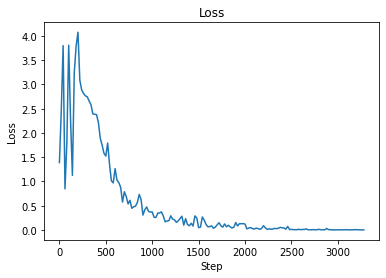

In [27]:
plt.plot(x, losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title('Loss')
plt.show()

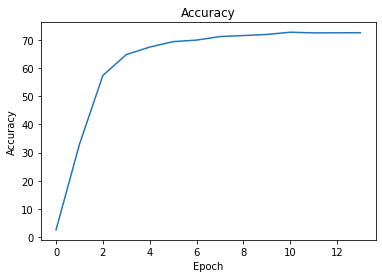

In [28]:
plt.plot(accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.show()